In [1]:
'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).
# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda

from keras.optimizers import RMSprop
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Flatten()(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [3]:
num_classes = 10
epochs = 5

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
print (input_shape)
print (x_train.shape)
print (y_train[1])

(28, 28)
(60000, 28, 28)
0


In [4]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
#print (len(digit_indices[5]))
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [6]:
tr_pairs.shape, tr_y.shape

((108400, 2, 28, 28), (108400,))

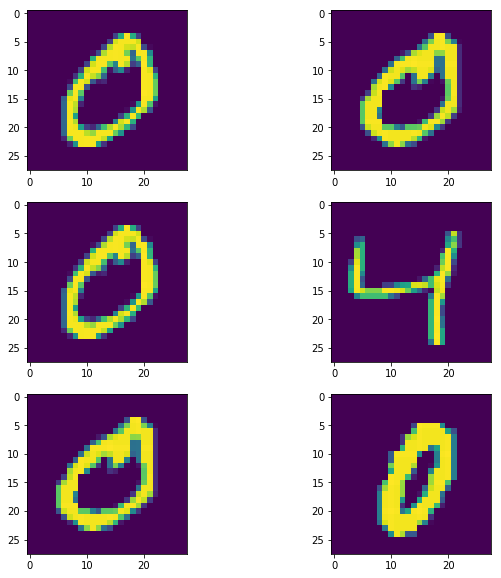

[1 0 1]


In [5]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

ax[0][0].imshow(tr_pairs[0][0])
ax[0][1].imshow(tr_pairs[0][1])
ax[1][0].imshow(tr_pairs[1][0])
ax[1][1].imshow(tr_pairs[1][1])
ax[2][0].imshow(tr_pairs[2][0])
ax[2][1].imshow(tr_pairs[2][1])
plt.show()

print (tr_y[0:3])


In [13]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)
import warnings
warnings.filterwarnings('ignore')

ValueError: Input 0 is incompatible with layer flatten_3: expected min_ndim=3, found ndim=2

In [7]:
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

In [8]:
model = Model([input_a, input_b], distance)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          133504      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [9]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Instructions for updating:
Use tf.cast instead.
Train on 108400 samples, validate on 17820 samples
Epoch 1/5
108400/108400 [==============================] - 11s 102us/step - loss: 0.0954 - accuracy: 0.8874 - val_loss: 0.0430 - val_accuracy: 0.9567
Epoch 2/5
108400/108400 [==============================] - 7s 68us/step - loss: 0.0399 - accuracy: 0.9612 - val_loss: 0.0310 - val_accuracy: 0.9666
Epoch 3/5
108400/108400 [==============================] - 9s 86us/step - loss: 0.0275 - accuracy: 0.9727 - val_loss: 0.0259 - val_accuracy: 0.9705
Epoch 4/5
108400/108400 [==============================] - 8s 70us/step - loss: 0.0219 - accuracy: 0.9774 - val_loss: 0.0237 - val_accuracy: 0.9715
Epoch 5/5
108400/108400 [==============================] - 8s 77us/step - loss: 0.0185 - accuracy: 0.9804 - val_loss: 0.0227 - val_accuracy: 0.9723


In [10]:
# compute final accuracy on training and test sets
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)

y_pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_te)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 98.89%
* Accuracy on test set: 97.23%


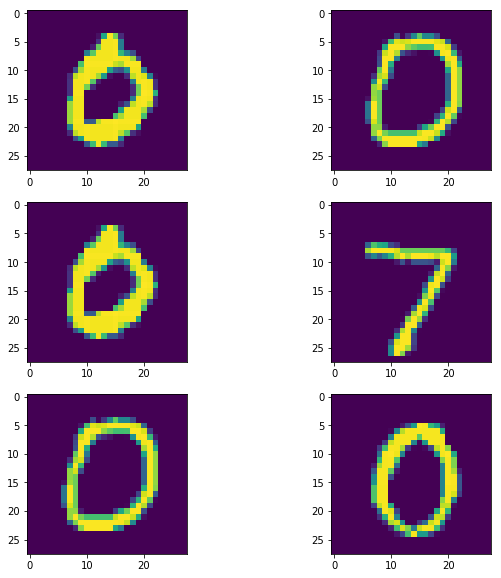

[[0.02640714]
 [1.1178241 ]
 [0.01233226]]


In [11]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))
ax[0][0].imshow(te_pairs[0][0])
ax[0][1].imshow(te_pairs[0][1])
ax[1][0].imshow(te_pairs[1][0])
ax[1][1].imshow(te_pairs[1][1])
ax[2][0].imshow(te_pairs[2][0])
ax[2][1].imshow(te_pairs[2][1])
plt.show()

print (y_pred_te[0:3])
